In [1]:
import numpy as np
import librosa
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# speech-silence and voice-unvoiced
def read_lab(lab_file_name: str):
    data = []
    with open(lab_file_name) as f:
        for line in f.readlines():
            data.append(line.split())
    return data


def get_closest(array_time, values):
    array_time = np.array(array_time)
    values = np.array(values, dtype=np.float64)
    idx = np.searchsorted(array_time, values)
    idx = np.array(idx)
    idx[array_time[idx] - values > np.diff(array_time).mean() * 0.5] -= 1
    return array_time[idx]


def get_closest_idx(array_time, values):
    array_time = np.array(array_time)
    values = np.array(values, dtype=np.float64)
    idx = np.searchsorted(array_time, values, side='left')
    idx = np.array(idx)   
    return idx


def array_norm(arr: np.ndarray):
    arr = np.copy(arr)
    max_arr = max(arr)
    min_arr = min(arr)
    return (arr - min_arr) / (max_arr - min_arr)

def array_norm_by_T(arr: np.ndarray, T):
    min_arr=min(arr)
    max_arr=max(arr)
    return np.where(arr>=T, (arr-T)/(max_arr-T), (arr-T)/(T-min_arr))

def remove_sl(array: np.ndarray, timestamp_label, t):
    new_array = np.array([])
    for line in timestamp_label:
        if line[2] != 'sil':
            try:
                idx1 = int(get_closest_idx(t, line[0]))
                idx2 = int(get_closest_idx(t, line[1]))
                new_array = np.append(new_array, array[idx1:idx2])
            except:
                print(line)
    return new_array


def load_data(audio_name: str):
    signal, sr = librosa.load(f'{audio_name}.wav')
    lab_data = read_lab(f'{audio_name}.lab')
    mean_std = lab_data[-2:]
    lab_data = lab_data[:-2]
    timestamp_label = list(filter(lambda x: (x[2] == 'v' or x[2] == 'uv'), lab_data))
    t_i = 0
    t_f = signal.shape[0] / sr
    t = np.linspace(t_i, t_f, num=signal.shape[0])
    t_without_sl = remove_sl(t, timestamp_label, t)
    signal = remove_sl(signal, timestamp_label, t)
    return signal, sr, t_without_sl, timestamp_label


def separate_frames(signal, sr, t, frame_length=0.025):
    frame_size = int(sr * frame_length)
    frame_count = len(signal) // frame_size
    temp = 0
    signal_frames = []
    time_frames = []
    for i in range(0, frame_count * frame_size, frame_size):
        signal_frames.append(signal[i:i + frame_size])
        time_frames.append(t[i:i + frame_size])
    return np.array(signal_frames), np.array(time_frames), frame_size, frame_count


def calc_STE(signal_frames):
    STE = []
    frame_size=len(signal_frames[0])
    frames_count=len(signal_frames)
    for i in range(frames_count):
        value = np.sum(np.square(signal_frames[i])) / np.ones(frame_size)
        STE.append(value)
    STE = np.array(STE)

    STE = STE.reshape(-1)
    STE = array_norm(STE)
    return STE


def calc_ZCR(signal_frames):
    ZCR = []
    frames_count=len(signal_frames)
    frame_size=len(signal_frames[0])
    for i in range(frames_count):
        value = np.sum(np.abs(np.diff(np.sign(signal_frames[i])))) / np.ones(frame_size)
        ZCR.append(value)
    ZCR = np.array(ZCR)
    ZCR = ZCR.reshape(-1)
    ZCR = array_norm(ZCR)
    return ZCR


def separate_vu(STE, timestamp_label, t):
    STE_v = np.array([])
    STE_uv = np.array([])
    for line in timestamp_label:
        if line[2] == 'v':
            try:
                idx1 = int(get_closest_idx(t, line[0]))
                idx2 = int(get_closest_idx(t, line[1]))
                STE_v = np.append(STE_v, STE[idx1:idx2])
            except:
                print(line)
        if line[2] == 'uv':
            try:
                idx1 = int(get_closest_idx(t, line[0]))
                idx2 = int(get_closest_idx(t, line[1]))
                STE_uv = np.append(STE_uv, STE[idx1:idx2])
            except:
                print(line)
    return np.array(STE_v), np.array(STE_uv)


def calc_T_binsearch(g, f):
    Nf = len(f)
    Ng = len(g)
    Tmax = max(np.max(f), np.max(g))
    Tmin = min(np.min(f), np.min(g))
    T = (Tmax + Tmin) / 2
    j = -1
    q = -1
    p = sum(g > T)
    i = sum(f < T)
    while j != j or p != q:
        if 1 / Nf * np.sum(f[f > T] - T) - 1 / Ng * np.sum(T - g[g < T]) > 0:
            Tmin = T
        else:
            Tmax = T
        T = (Tmax + Tmin) / 2
        p = sum(g > T)
        i = sum(f < T)
        j = i
        q = p
    return T

def jitter_remove(VU_jit, frame_size):
    frames_count=len(VU_jit)//frame_size
    STA_VU=np.array([])
    for i in range(0, frames_count*frame_size, frame_size):
        STA_VU=np.append(STA_VU, np.sum(VU_jit[i:i+frame_size])/np.ones(frame_size))
    STA_VU=1/frame_size*STA_VU
    VU=np.where(STA_VU>=0.5, 1, 0)
    return VU


def plot_voiced_unvoiced(audio_name, signal, t, timestamp_label, STE, ZCR, VU, renderer='notebook'):
    fig = make_subplots(rows=3, cols=1)
    fig.add_trace(go.Scatter(x=t, y=signal, name='signal', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=STE, name='STE'), row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=ZCR, name='ZCR'), row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=signal, name='signal', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=signal, name='signal', line=dict(color='blue')), row=3, col=1)
    fig.add_trace(go.Scatter(x=t, y=VU, name='VU'), row=1, col=1)
    for i in range(len(timestamp_label)):
        color = 'green' if timestamp_label[i][2] == 'v' else 'blue'
        fig.add_vrect(x0=float(timestamp_label[i][0]), x1=float(timestamp_label[i][1]),
                    fillcolor=color,
                    opacity=0.25, line_width=0, row=2, col=1)
    for i in range(len(timestamp_label)):
        color = 'green' if timestamp_label[i][2] == 'v' else 'blue'
        fig.add_vrect(x0=float(timestamp_label[i][0]), x1=float(timestamp_label[i][1]),
                    fillcolor=color,
                    opacity=0.25, line_width=0, row=1, col=1)
    VU_sep=np.diff(VU)
    cal_timestamp_label=[]
    first_timestamp=0
    temp_timestamp=[]
    for i in range(len(VU_sep)):
        if first_timestamp==0:
            if VU_sep[i]==-1:
                cal_timestamp_label.append([t[0], t[i], 'v'])
                temp_timestamp=[t[i], 'uv']
                first_timestamp=1
            if VU_sep[i]==1:
                cal_timestamp_label.append([t[0], t[i], 'uv'])
                temp_timestamp=[t[i], 'v']
                first_timestamp=1
            continue
        if VU_sep[i] == -1:
            cal_timestamp_label.append([temp_timestamp[0], t[i], temp_timestamp[1]])
            temp_timestamp=[t[i], 'uv']
            continue
        if VU_sep[i]==1:
            cal_timestamp_label.append([temp_timestamp[0], t[i], temp_timestamp[1]])
            temp_timestamp=[t[i], 'v']
            continue
        if i==len(VU_sep)-1:
            cal_timestamp_label.append([temp_timestamp[0], t[i], temp_timestamp[1]])
    for i in range(len(cal_timestamp_label)):
        color = 'green' if cal_timestamp_label[i][2] == 'v' else 'blue'
        fig.add_vrect(x0=float(cal_timestamp_label[i][0]), x1=float(cal_timestamp_label[i][1]),
                    fillcolor=color,
                    opacity=0.25, line_width=0, row=3, col=1)
    fig.update_layout(
        title=audio_name
    )
    fig.show(renderer)

In [2]:

def voiced_unvoiced(audio_name_list, plot_name_list):
    signal_list=[0]*len(audio_name_list)
    sr_list=[0]*len(audio_name_list)
    t_list=[0]*len(audio_name_list)
    timestamp_label_list=[0]*len(audio_name_list)
    signal_frames_list=[0]*len(audio_name_list)
    time_frames_list=[0]*len(audio_name_list)
    frame_size_list=[0]*len(audio_name_list)
    frames_count_list=[0]*len(audio_name_list)
    STE_list=[0]*len(audio_name_list)
    ZCR_list=[0]*len(audio_name_list)
    STE_voiced_list=[0]*len(audio_name_list)
    STE_unvoiced_list=[0]*len(audio_name_list)
    ZCR_voiced_list=[0]*len(audio_name_list)
    ZCR_unvoiced_list=[0]*len(audio_name_list)
    T_STE_list=[0]*len(audio_name_list)
    T_ZCR_list=[0]*len(audio_name_list)
    for i in range(len(audio_name_list)):
        signal_list[i], sr_list[i], t_list[i], timestamp_label_list[i] = load_data(audio_name_list[i])
        signal_frames_list[i], time_frames_list[i], frame_size_list[i], frames_count_list[i] = separate_frames(signal_list[i], sr_list[i], t_list[i])
        signal_list[i]=signal_list[i][:frames_count_list[i]*frame_size_list[i]]
        t_list[i]=t_list[i][:frames_count_list[i]*frame_size_list[i]]
        STE_list[i] = calc_STE(signal_frames_list[i])
        ZCR_list[i] = calc_ZCR(signal_frames_list[i])
        STE_voiced_list[i], STE_unvoiced_list[i] = separate_vu(STE_list[i], timestamp_label_list[i], t_list[i])
        ZCR_voiced_list[i], ZCR_unvoiced_list[i] = separate_vu(ZCR_list[i], timestamp_label_list[i], t_list[i])
    T_STE_list[0] = calc_T_binsearch(np.concatenate(STE_voiced_list), np.concatenate(STE_unvoiced_list))
    T_ZCR_list[0] = calc_T_binsearch(np.concatenate(ZCR_voiced_list), np.concatenate(ZCR_unvoiced_list))
    for i in range(1, len(audio_name_list)):
        T_STE_list[i] = T_STE_list[0]
        T_ZCR_list[i] = T_ZCR_list[0]
    STE_norm_T_list=[0]*len(audio_name_list)
    ZCR_norm_T_list=[0]*len(audio_name_list)
    VU_jit_list=[0]*len(audio_name_list)
    VU_list=[0]*len(audio_name_list)
    for i in range(len(audio_name_list)):
        STE_norm_T_list[i]=array_norm_by_T(STE_list[i], T_STE_list[i])
        ZCR_norm_T_list[i]=array_norm_by_T(ZCR_list[i], T_ZCR_list[i])
        VU_jit_list[i]=np.sign(STE_norm_T_list[i]-ZCR_norm_T_list[i])
        VU_list[i]=jitter_remove(VU_jit_list[i], frame_size_list[i])
        if audio_name_list[i] in plot_name_list:
            plot_voiced_unvoiced(audio_name_list[i], signal_list[i], t_list[i], timestamp_label_list[i], STE_list[i], ZCR_list[i], VU_list[i], renderer='svg')

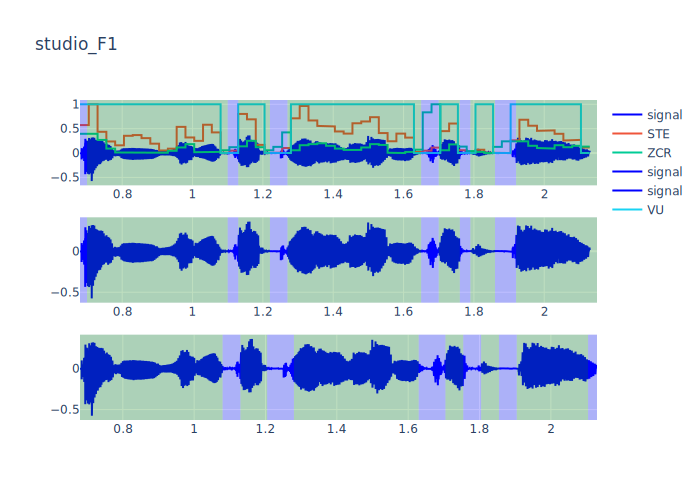

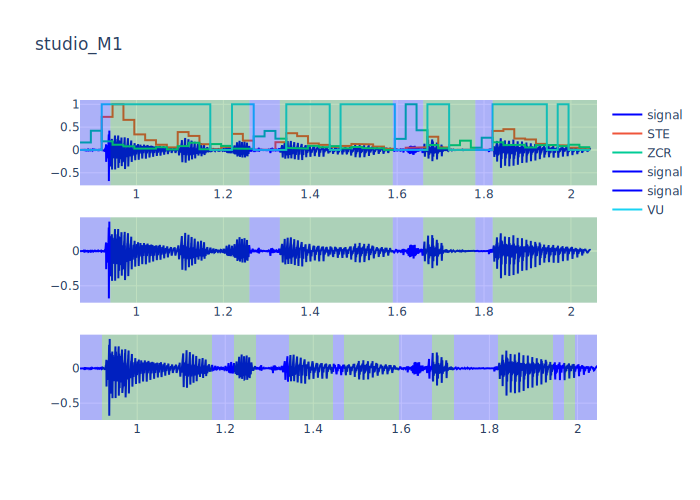

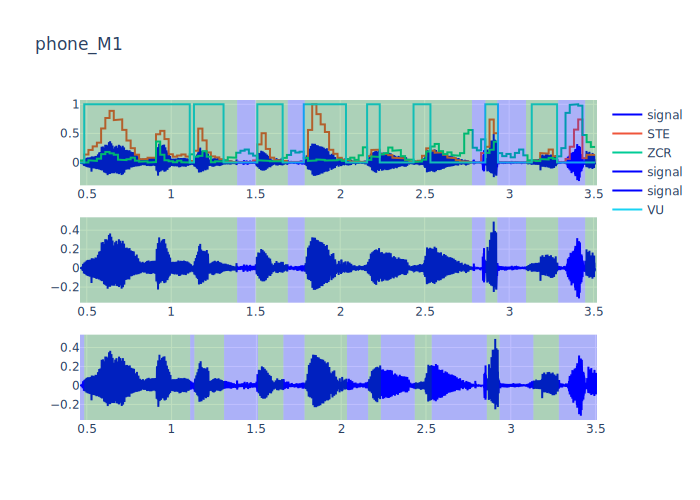

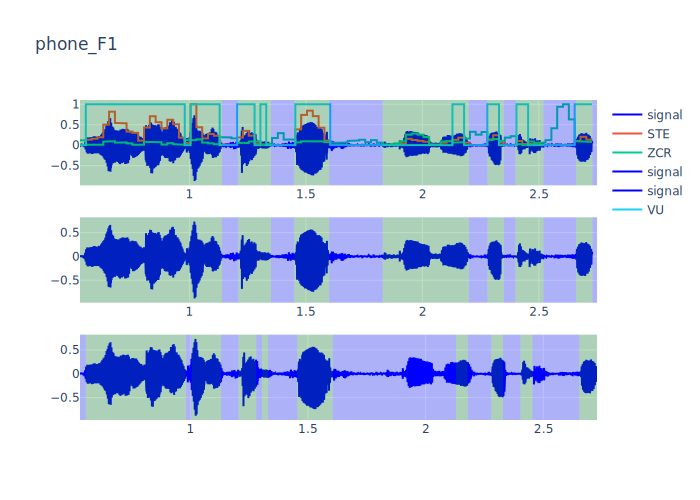

In [5]:
audio_name_list=['studio_F1', 'studio_M1', 'phone_M1', 'phone_F1']
plot_name_list=['studio_F1', 'studio_M1', 'phone_M1', 'phone_F1']
voiced_unvoiced(audio_name_list, plot_name_list)
